## Azhar Rizki Zulma

Dataset: https://www.kaggle.com/robikscube/hourly-energy-consumption?select=EKPC_hourly.csv

East Kentucky Power Cooperative (EKPC)

estimated energy consumption in Megawatts (MW)

### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.backend import clear_session

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Read Data

In [2]:
df = pd.read_csv('/EKPC_hourly.csv')
df

,Datetime,EKPC_MW
0,2013-12-31 01:00:00,1861.0
1,2013-12-31 02:00:00,1835.0
2,2013-12-31 03:00:00,1841.0
3,2013-12-31 04:00:00,1872.0
4,2013-12-31 05:00:00,1934.0
...,...,...
45329,2018-01-01 20:00:00,2866.0
45330,2018-01-01 21:00:00,2846.0
45331,2018-01-01 22:00:00,2883.0
45332,2018-01-01 23:00:00,2880.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  45334 non-null  object 
 1   EKPC_MW   45334 non-null  float64
dtypes: float64(1), object(1)
memory usage: 708.5+ KB


In [4]:
df['date']=pd.to_datetime(df['Datetime'])
df.head()

,Datetime,EKPC_MW,date
0,2013-12-31 01:00:00,1861.0,2013-12-31 01:00:00
1,2013-12-31 02:00:00,1835.0,2013-12-31 02:00:00
2,2013-12-31 03:00:00,1841.0,2013-12-31 03:00:00
3,2013-12-31 04:00:00,1872.0,2013-12-31 04:00:00
4,2013-12-31 05:00:00,1934.0,2013-12-31 05:00:00


Create new dataframe with only 2 colum (date & value)

In [5]:
energy=df[['date','EKPC_MW']].copy()
energy['val'] = energy['EKPC_MW']
energy = energy.drop('EKPC_MW', axis=1)
energy.sort_values(by=['date'], inplace=True, ascending=False)
energy.set_index('date', inplace= True)
energy.head()

,val
date,
2018-08-03 00:00:00,1448.0
2018-08-02 23:00:00,1619.0
2018-08-02 22:00:00,1756.0
2018-08-02 21:00:00,1769.0
2018-08-02 20:00:00,1815.0


### Timeseries Plot

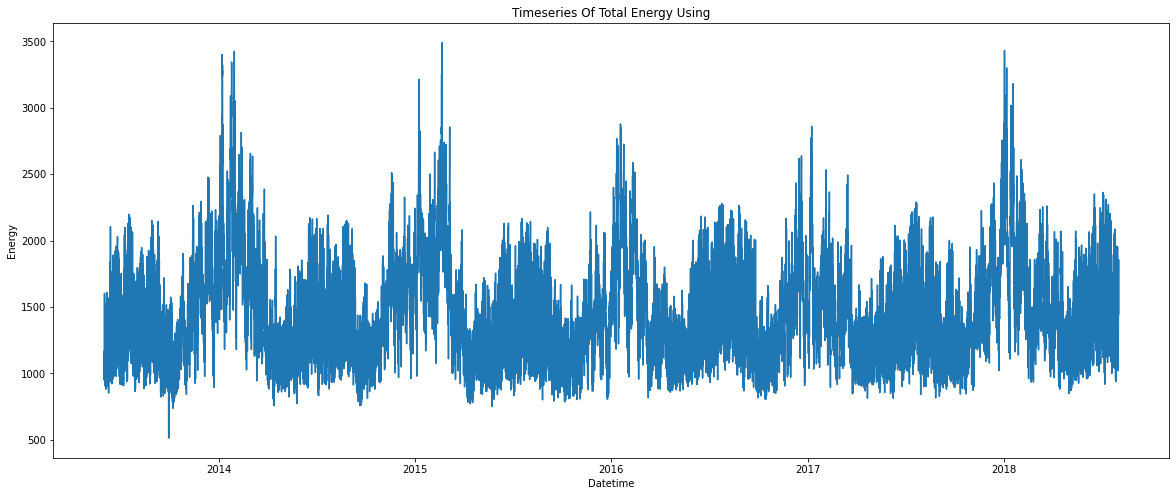

In [6]:
plt.figure(figsize=(20,8))
plt.plot(energy)
plt.title('Timeseries Of Total Energy Using')
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.show()

### Modelling

In [7]:
date = df['date'].values
val = energy['val'].values

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(val, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

36267 9067


In [10]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

**Min & Max Value**

In [12]:
min = energy['val'].min()
print('Min Value : ')
print(min)

max = energy['val'].max()
print('Max value : ' )
print(max)

Min Value : 
514.0
Max value : 
3490.0


In [13]:
x = (max - min) * (10/100)
print(x)

297.6


In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae')< x) and (logs.get('val_mae')< x)):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [15]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train, epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
363/363 [==============================] - 50s 103ms/step - loss: 1336.9884 - mae: 1337.4876 - val_loss: 1283.1686 - val_mae: 1283.6685
Epoch 2/500
363/363 [==============================] - 18s 46ms/step - loss: 1198.5083 - mae: 1199.0080 - val_loss: 1169.9294 - val_mae: 1170.4298
Epoch 3/500
363/363 [==============================] - 19s 50ms/step - loss: 1090.1339 - mae: 1090.6343 - val_loss: 1060.7694 - val_mae: 1061.2694
Epoch 4/500
363/363 [==============================] - 21s 54ms/step - loss: 976.3504 - mae: 976.8502 - val_loss: 941.9280 - val_mae: 942.4281
Epoch 5/500
363/363 [==============================] - 18s 46ms/step - loss: 851.1517 - mae: 851.6521 - val_loss: 810.5733 - val_mae: 811.0733
Epoch 6/500
363/363 [==============================] - 18s 46ms/step - loss: 711.3888 - mae: 711.8887 - val_loss: 663.8822 - val_mae: 664.3821
Epoch 7/500
363/363 [==============================] - 18s 47ms/step - loss: 563.8914 - mae: 564.3912 - val_loss: 526.9086 - val_

### Plot Loss & Mae

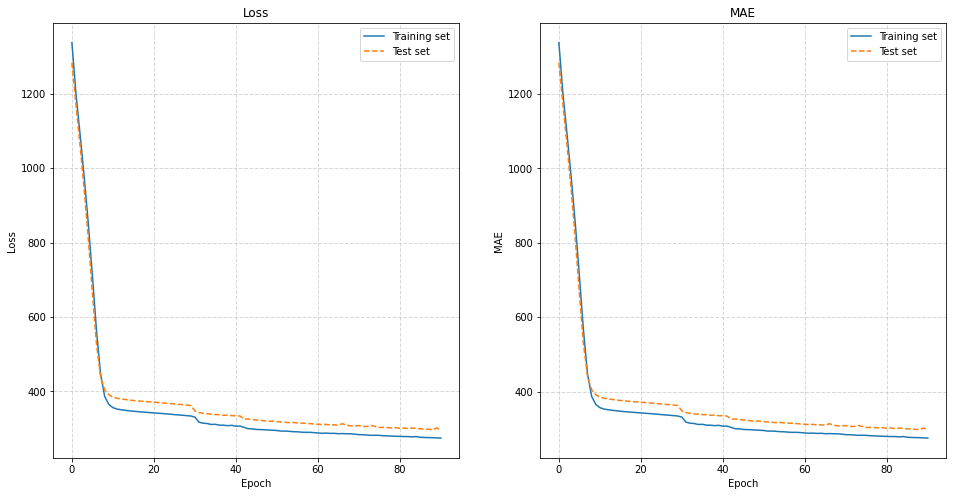

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(mae, label='Training set')
plt.plot(val_mae, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()